# Concrete Strength - Machine Learning
This project has the goal of predicting the concrete strength based on some features.

## Data
The dataset was provided by Kaggle: https://www.kaggle.com/datasets/maajdl/yeh-concret-data
And ahs the following sctructure:

* `Cement`: kg in a m3 mixture
* `Blast Furnace Slag`: kg in a m3 mixture
* `Fly Ash`: kg in a m3 mixture
* `Water`: kg in a m3 mixture
* `Superplasticizer`: kg in a m3 mixture
* `Coarse Aggregate`: kg in a m3 mixture
* `Fine Aggregate`: kg in a m3 mixture
* `Age`: Day (1~365) 
* `Concrete compressive strength`: MPa (target)

## Importing tools

In [1]:
# utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# models(estimators)
from sklearn.linear_model import Ridge
from sklearn.svm import SVR # kernl='linear' and kernel='rbf'
from sklearn.ensemble import RandomForestRegressor


In [2]:
# getting the data
df = pd.read_csv("data/concrete_data.csv")
df.sort_values(by=["csMPa"], ascending=False, inplace=True)

# top 5 strength
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
181,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
381,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
153,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
159,389.9,189.0,0.0,145.9,22.0,944.7,755.8,56,79.40


In [3]:
# bottom 5 strength
df.tail()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
717,141.3,212.0,0.0,203.5,0.0,971.8,748.5,3,4.83
668,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3,4.78
652,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
705,122.6,183.9,0.0,203.5,0.0,958.2,800.1,3,3.32
688,108.3,162.4,0.0,203.5,0.0,938.2,849.0,3,2.33


In [4]:
len(df)

1030

In [5]:
# checking for missing values
df.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

In [6]:
# checking for duplicates
df.duplicated().sum()

25

In [7]:
# removing duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Correlation Matrix

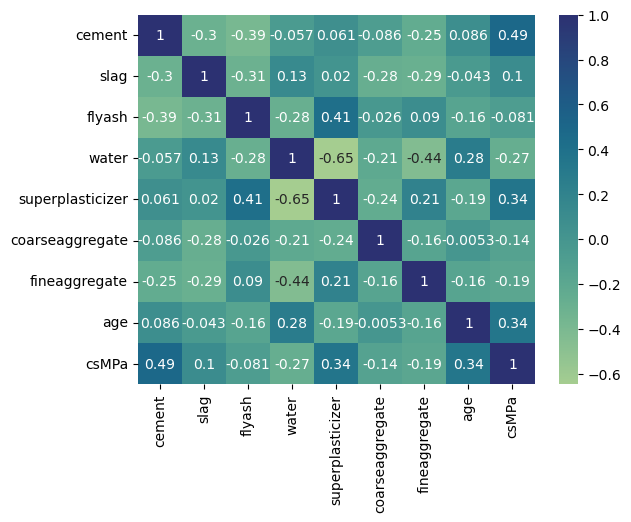

In [8]:
corr = df.corr()
sn.heatmap(corr, annot=True, cmap="crest")
plt.show()

### Ploting potential features

### Cement x Strength

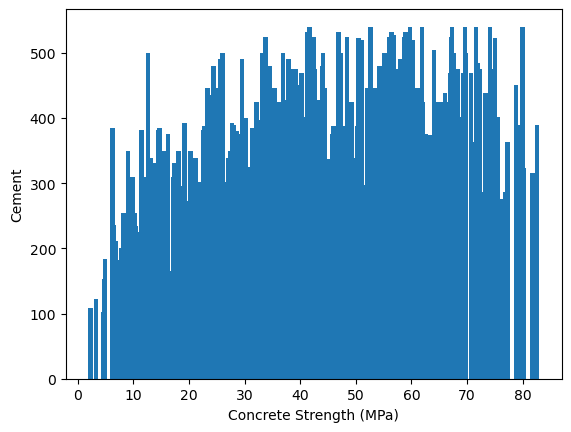

In [9]:
fig, ax = plt.subplots()
ax.bar(df.csMPa, df.cement)
ax.set(xlabel="Concrete Strength (MPa)", ylabel="Cement")
plt.show()

It is kinda visible a slight curve ascending. 

### Superplasticize x Strength

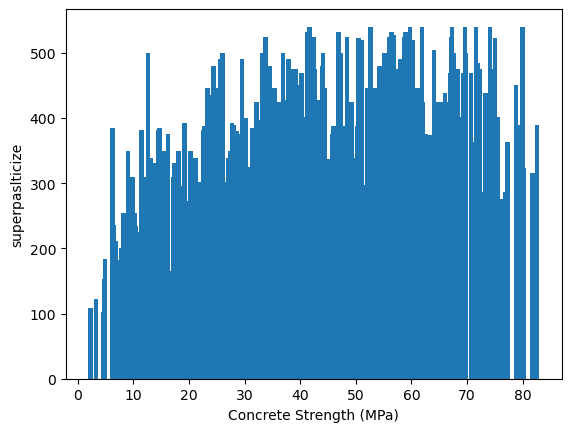

In [10]:
fig, ax = plt.subplots()
ax.bar(df.csMPa, df.cement)
ax.set(xlabel="Concrete Strength (MPa)", ylabel="superpaslticize")
plt.show()

Again kinda a ascending curve

## Modeling